# Classification from images with VGG-16

In this example we build a clasification model to recognise differnet kinds of images. This example uses limited data and is inspired by the keras blog post "Building powerful image classification models using very little data" from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html. This example also uses a VGG-16 pre-trained model fine tuned for a specifc problem.

The datasets used are from kaggle 
* cats and dogs https://www.kaggle.com/c/dogs-vs-cats
* monkeys https://www.kaggle.com/slothkong/10-monkey-species/home 
* flowers https://www.kaggle.com/alxmamaev/flowers-recognition

In [17]:
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn import svm

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL

## Data

Set up the data set process. We provide the name of a folder contianing images. There are two assumptions:
* The images of differnet classes are contained in folders with class ids
* A csv file called class_labels exists which is a map from class ids to class names (for printing)

In [4]:
# dataset name
dataset_name = 'flowers'

# assuming data is contained in a train and a validation set
train_data_dir = dataset_name + '/train/'

# Set up some parmaeters for data loading
sample_rate = 0.1

# desired dimensions of our images.
img_width, img_height = 150, 150

# Set input shape
input_shape = (img_width, img_height, 3)

Load image data.

In [5]:
training_class_folders = [i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset
num_classes = len(training_class_folders)

# Initialise arrays for data storage
X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.str)
    
# Loop through the class folders
for i, image_cls in enumerate(training_class_folders):
    
    print('Processing class {}'.format(image_cls))
    image_class_folder = train_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for image data
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

    # Iterate throuigh the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(image_filenames):

        # Low the images and resize them
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)        
        image = image[:,:,[2,1,0]] # OpenCV and matplotlib use differnet channel oerderings so fix this
        
        # If channel order of network does not match open cv format swap it
#        if K.image_data_format() == 'channels_first':
#            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        # Add label to label array
        y_data = np.append(y_data, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array
    X_data = np.append(X_data, X_data_part, axis=0)
    
print("Data shape: {}".format(X_data.shape))

Processing class daisy
Processed 0 of 76 for class daisy 
Processed 76 of 76 for class daisy 
Processing class rose
Processed 0 of 78 for class rose 
Processed 78 of 78 for class rose 
Processing class tulip
Processed 0 of 98 for class tulip 
Processed 98 of 98 for class tulip 
Processing class dandelion
Processed 0 of 105 for class dandelion 
Processed 100 of 105 for class dandelion 
Processed 105 of 105 for class dandelion 
Processing class sunflower
Processed 0 of 73 for class sunflower 
Processed 73 of 73 for class sunflower 
Data shape: (430, 150, 150, 3)


Split data into training and test partitions

In [6]:
# Perfrom split to train, validation, test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

Reshape output data for use with a neural network.

In [7]:
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = to_categorical(y_test_num, num_classes)

Record the number to label mapping 

In [8]:
classes_num_label = dict()

for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl

Print a few randomly sampled example images.

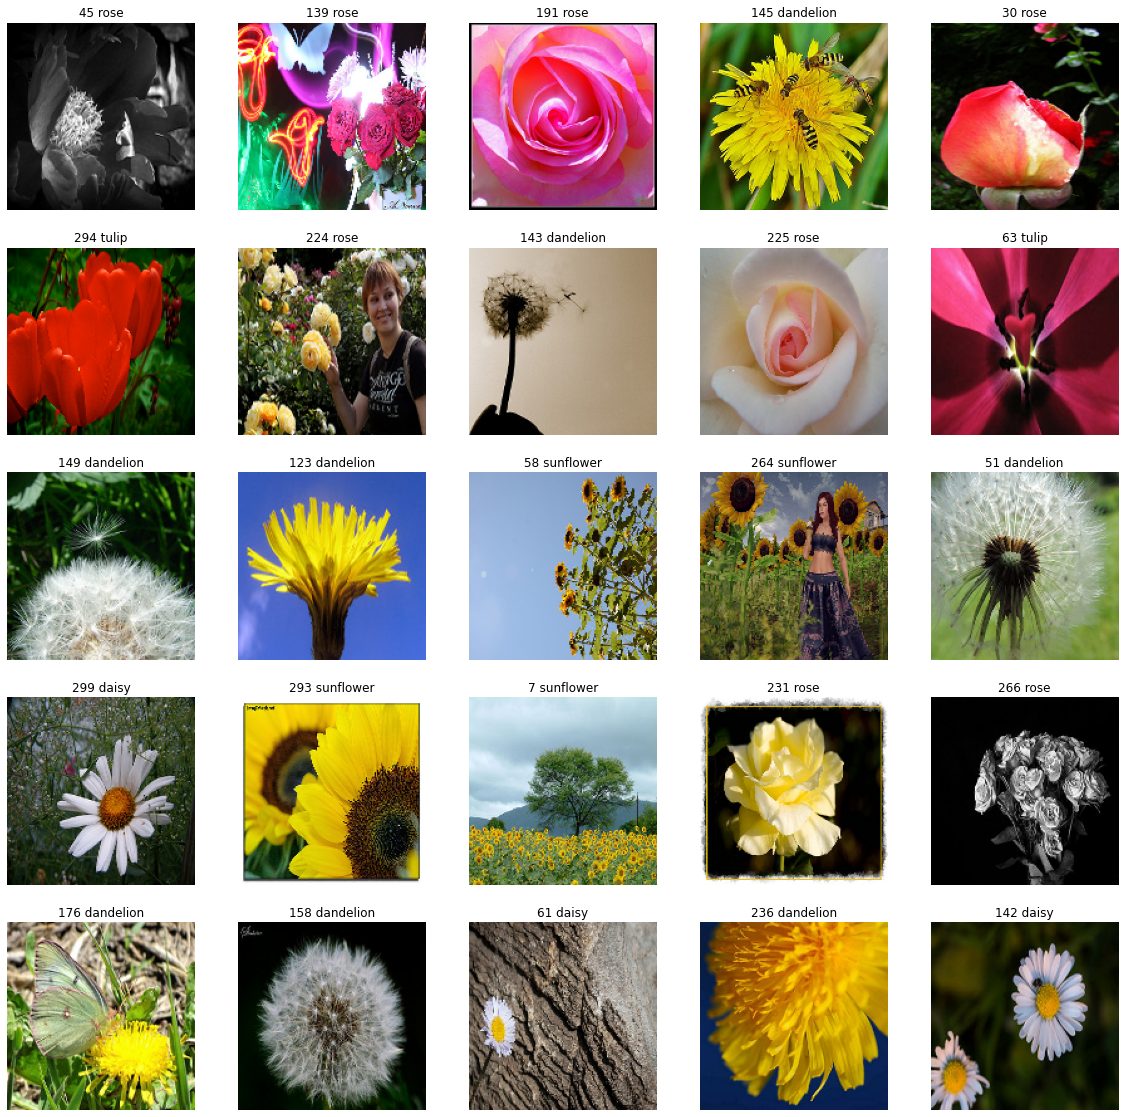

In [9]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(PIL.Image.fromarray(((X_train[i_rand]) * 255).astype(np.uint8)))
    plt.title((str(i_rand) + " " + y_train[i_rand]))

## Modelling

Create model architecture

In [13]:
# build the VGG16 network
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape = X_train[0].shape)
display(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

None

In [18]:
vgg16_last_layer = vgg16_model.output

# build a classifier model to put on top of the VGG16 model
x1 = Flatten()(vgg16_last_layer)
x2 = Dense(256, activation='relu')(x1)
x3 = Dropout(0.5)(x2)
final_layer = Dense(num_classes, activation = 'softmax')(x3)

# Assemble the full model out of both parts
full_model = Model(vgg16_model.input, final_layer)

# moving over weights from a pre-trained smaller model specifically for our problem might help rather than random initialisation.
#top_weights_filepath = './best_weights_notebook22.hdf5'
#old_model = keras.models.load_model(top_weights_filepath)
#full_model.layers[-1].set_weights(old_model.layers[-1].get_weights())

# set the first 17 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in vgg16_model.layers:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
full_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Train the model. We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [ ]:
batch_size = 128
epochs = 10

# Set up the callback to save the best model based on validaion data - notebook 2.2 needs to be run first.
best_weights_filepath = './best_weights_notebook23.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = full_model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
#model.load_weights(best_weights_filepath)

Epoch 1/10
2/2 [==============================] - 23s 13s/step - loss: 0.8259 - accuracy: 0.3333 - val_loss: 0.5318 - val_accuracy: 0.5246
Epoch 2/10
2/2 [==============================] - 40s 28s/step - loss: 0.4974 - accuracy: 0.4708 - val_loss: 0.4010 - val_accuracy: 0.4590
Epoch 3/10


Plot some evaluation stats

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(accuracy, 'blue', label='Training Accuracy')
plt.plot(val_accuracy, 'green', label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [ ]:
# Make a set of predictions for the validation data
pred = np.argmax(full_model.predict(X_train),axis=1)

# Print performance details
print(metrics.classification_report(y_train_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred))

## Evaluation

In [ ]:
# Make a set of predictions for the validation data
pred = np.argmax(full_model.predict(X_test),axis=1)

# Print performance details
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

In [ ]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray(((X_test[i]) * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1

Draw some examples of mis-classifications 

In [ ]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
errors = predictions != y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray(((X_test[i]) * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1